### Building a classification model with Scikit learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import os
import cv2
import pickle


In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2024-05-01 15:00:17--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-05-01 15:00:17--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-05-01 15:00:18--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [ ]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

In [ ]:
from IPython.display import Image

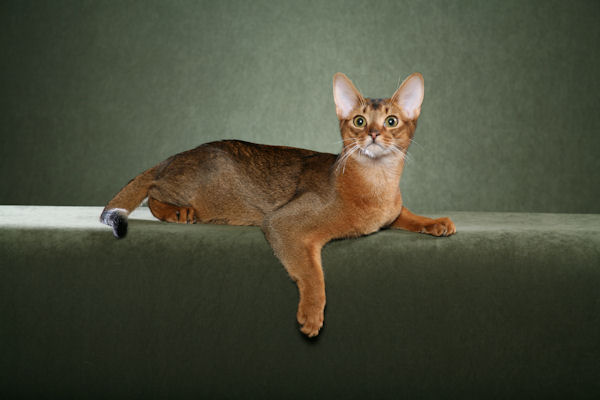

In [ ]:
Image('/content/images/Abyssinian_1.jpg')

**Checking the size of the images : they don't seem to be of different size**

In [ ]:
from PIL import Image
import os

# Path to the image folder
image_folder = '/content/images/'  # Replace with your folder path

# List all files in the image folder
image_files = os.listdir(image_folder)

# Iterate over each image file and read it
for filename in image_files[:5]:
    # Join the folder path with the filename
    filepath = os.path.join(image_folder, filename)

    # Open the image file
    with Image.open(filepath) as img:
        # Display the image (optional)
        # img.show()
        print(np.array(img).shape)


(375, 500, 3)
(375, 500, 3)
(333, 500, 3)
(300, 400, 3)
(230, 500, 3)


#### Resizing all the images to a standard size

*Defining a fucntion to load the image path files and labels  into two separate lists*

*Next we want to iterate through the image paths that we created and read the images and reshape to a standard size*

*Next we want to convert the images and labels to numpy arrays, which we finally return from the function*

In [ ]:
def load_data(images_dir, annotations_dir, target_shape=(150, 150)):
    # Read list.txt to get image paths and corresponding labels
    with open(os.path.join(annotations_dir, 'list.txt'), 'r') as file:
        lines = file.readlines()
        image_paths = []
        labels = []
        for line in lines:
            if not line.startswith('#'):  # Skip lines starting with '#'
                line = line.strip().split()
                image_path = os.path.join(images_dir, line[0] + '.jpg')
                if os.path.exists(image_path):  # Check if image file exists
                    image_paths.append(image_path)
                    labels.append(int(line[2]) - 1)  # Species: 1 for Cat, 2 for Dog => 0 for Cat, 1 for Dog
                else:
                    print(f"Image not found: {image_path}")

    # Load and resize images
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        if image is not None:  # Check if image was successfully loaded
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, target_shape)  # Resize image to target shape
            images.append(image)
        else:
            print(f"Error loading image: {path}")

    # Convert images and labels to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

#### Splitting the data into training and test and training a classifier

In [ ]:
# Define directories
images_dir = '/content/images'
annotations_dir = '/content/annotations'

# Load data
images, labels = load_data(images_dir, annotations_dir)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Train SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6802721088435374


In [ ]:
# saving the model
with open('svm_classifier_model.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

In [ ]:
# loading the model
with open('svm_classifier_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
# Now you can use the loaded model to make predictions on new images
def predict_image_class(image_path, loaded_model):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (150, 150))  # Assuming you trained the model with images of size (150, 150)
    image = image.reshape(1, -1)  # Flatten the image

    # Make prediction
    prediction = loaded_model.predict(image)
    print(prediction)
    return prediction[0]  # Return the predicted class

In [ ]:
# Example usage:
new_image_path = '/content/cat-1.jpg'
predicted_class = predict_image_class(new_image_path, loaded_model)
if predicted_class == 0:
    print("Predicted class: Cat")
elif predicted_class == 1:
    print("Predicted class: Dog")
else:
    print("Unknown class")

[1]
Predicted class: Dog


### Creating a Segmentation Mask

In [ ]:
from skimage import io, color, filters, morphology
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border

In [ ]:
def load_data(images_dir, annotations_dir, target_shape=(150, 150)):
    # Read list.txt to get image paths and corresponding labels
    with open(os.path.join(annotations_dir, 'list.txt'), 'r') as file:
        lines = file.readlines()
        image_paths = []
        # labels = []
        for line in lines:
            if not line.startswith('#'):  # Skip lines starting with '#'
                line = line.strip().split()
                image_path = os.path.join(images_dir, line[0] + '.jpg')
                if os.path.exists(image_path):  # Check if image file exists
                    image_paths.append(image_path)
                    # labels.append(int(line[2]) - 1)  # Species: 1 for Cat, 2 for Dog => 0 for Cat, 1 for Dog
                else:
                    print(f"Image not found: {image_path}")
        return image_paths

In [ ]:
# Load data
image_paths = load_data(images_dir, annotations_dir)

In [ ]:
image_paths[:3]

['/content/images/Abyssinian_100.jpg',
 '/content/images/Abyssinian_101.jpg',
 '/content/images/Abyssinian_102.jpg']

#### Otsu Thresholding

In [ ]:
for image_file in image_paths:
    # Load image
    image = io.imread(os.path.join(images_dir, image_file))

 # Discard alpha channel if present
    if image.shape[2] == 4:
        image = image[:, :, :3]  # Keep only RGB channels

    # Convert to grayscale
    gray_image = color.rgb2gray(image)

    # Thresholding
    threshold_value = threshold_otsu(gray_image)
    binary_image = gray_image > threshold_value

    # Clear border
    cleared_image = clear_border(binary_image)

    # Edge detection
    edge_image = filters.sobel(cleared_image)

    # Morphological operations
    # edge_image = morphology.binary_erosion(edge_image, morphology.disk(2))
    # edge_image = morphology.binary_dilation(edge_image, morphology.disk(2))

    # Combine foreground, background, and edge
    segmentation_mask = np.zeros_like(image, dtype=np.uint8)
    segmentation_mask[binary_image] = [255, 255, 255]  # Foreground
    segmentation_mask[~binary_image] = [0, 0, 0]       # Background
    # segmentation_mask[edge_image] = [0, 0, 255]        # Edge

    # Save segmentation mask
    io.imsave(os.path.join('/content/', image_file.replace('.jpg', '_mask.jpg')), segmentation_mask)

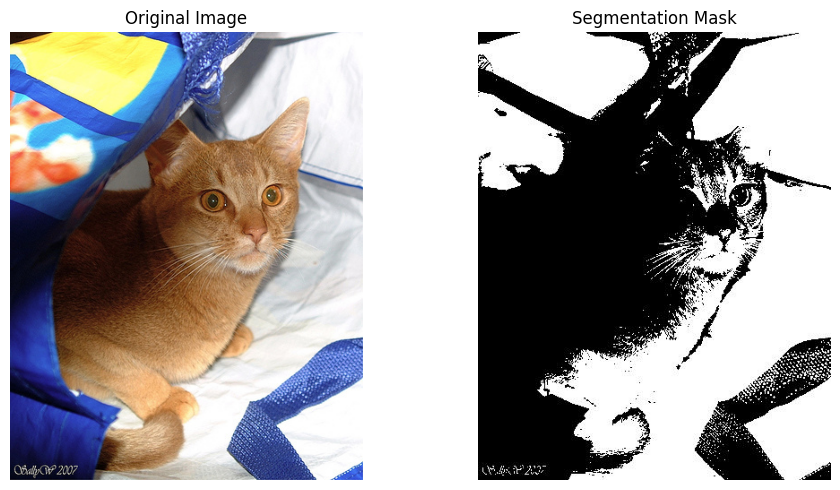

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()
image1 = io.imread('/content/images/Abyssinian_100.jpg')

ax[0].imshow(image1)
ax[0].set_title('Original Image')

image_mask = io.imread('/content/images/Abyssinian_100_mask.jpg')
ax[1].imshow(image_mask)
ax[1].set_title('Segmentation Mask')

# actual_mask = io.imread('/content/annotations/trimaps/._Abyssinian_100.png')
# ax[2].imshow(actual_mask)
# ax[2].set_title('actual_mask')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

<ipython-input-49-66686dbda3e3>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])


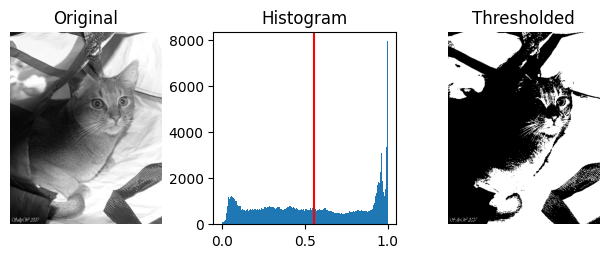

In [ ]:
image = color.rgb2gray(image1)
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

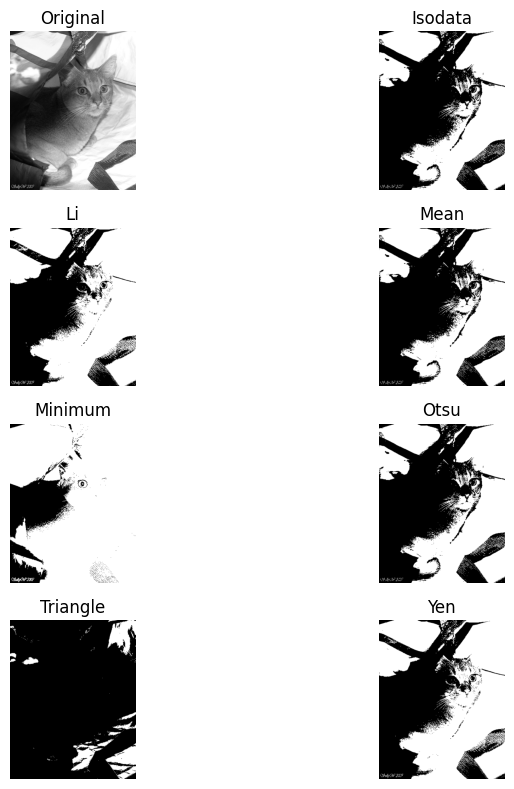

In [ ]:
from skimage.filters import try_all_threshold

img = image

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

#### Multi Otsu Thresholding

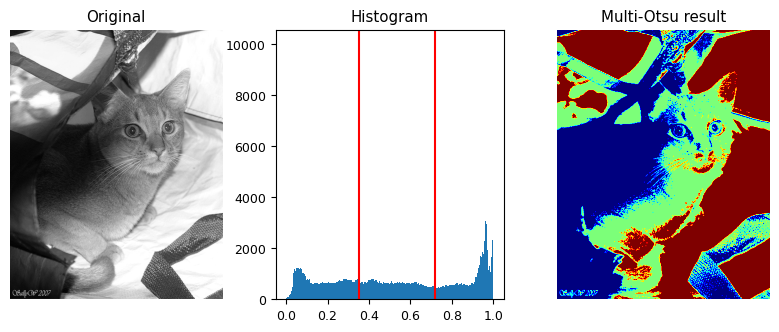

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = color.rgb2gray(image1)

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

### Object Segmentation using Neural Networks

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

#### Loading Dataset and Exploration

In [ ]:
dataset = tfds.load('oxford_iiit_pet', shuffle_files = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQEKSKN/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQEKSKN/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [ ]:
ds = dataset['train'].take(1)
print(ds)

<_TakeDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [ ]:
# Exploring sizes, and values in dataset
for example in ds:
  image = example["image"]
  mask = example["segmentation_mask"]
  print('Shapes:', image.shape, mask.shape)
  print('Image values:', tf.reduce_min(image), tf.reduce_max(image))
  print('Mask values:', tf.unique(tf.reshape(mask, [-1])))

Shapes: (500, 500, 3) (500, 500, 1)
Image values: tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)
Mask values: Unique(y=<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([2, 3, 1], dtype=uint8)>, idx=<tf.Tensor: shape=(250000,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


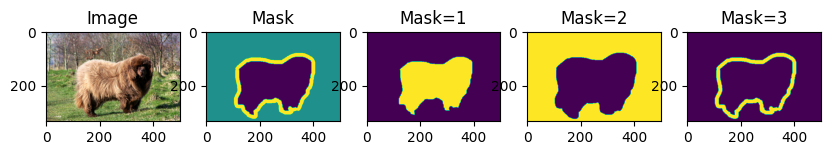

In [ ]:
# Displaying the dataset
for example in ds:
  image = example["image"]
  mask = example["segmentation_mask"]

  plt.figure(figsize=(10, 10))
  plt.subplot(1, 5, 1)
  plt.title('Image')
  plt.imshow(image)

  plt.subplot(1, 5, 2)
  plt.title('Mask')
  plt.imshow(mask)

  # Plotting the individual masks
  plt.subplot(1, 5, 3)
  plt.title('Mask=1')
  plt.imshow(mask==1)

  plt.subplot(1, 5, 4)
  plt.title('Mask=2')
  plt.imshow(mask==2)

  plt.subplot(1, 5, 5)
  plt.title('Mask=3')
  plt.imshow(mask==3)

In [ ]:
"""
Mask interpretation

1 - Object (foreground)
2 - Background
3 - Ambigious Region
"""

'\nMask interpretation\n\n1 - Object (foreground)\n2 - Background\n3 - Ambigious Region\n'

#### Pre-processing

In [ ]:
# 1. Standardize the image-mask sizes across the dataset
# 2. Train-test split

In [ ]:
dataset['train']

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
def normalize_img(data):
  """Normalizes images: `uint8` -> `float32`."""
  image = data['image']
  mask = data['segmentation_mask']
  image = tf.image.resize(image, [128, 128])
  mask = tf.image.resize(mask, [128, 128], method='nearest')
  image = tf.cast(image, tf.float32) / 255.0
  mask = tf.cast(mask-1, tf.float32)
  return image, mask

  # 1-1 = 0
  # 2-1 = 1
  # 3-1 = 2

In [ ]:
ds_train = dataset['train'].map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
ds_test = dataset['test'].map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(ds_train)

"""
Processed sizes:
Image: (batch_size, h, w, 3), float32, [0, 1]
Mask: (batch_size, h, w, 1), float32, [0, 1, 2]
"""

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


'\nProcessed sizes:\nImage: (batch_size, h, w, 3), float32, [0, 1]\nMask: (batch_size, h, w, 1), float32, [0, 1, 2]\n'

#### Model Building

In [ ]:
# Built with sequential APIs
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 68        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# built with functional APIs
inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 16        
                                                                 
 dense_3 (Dense)             (None, 5)                 25        
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [ ]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ugi4c5m4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ugi4c5m4
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=87a8d322553778b5993851b41d17bc5b396670ca98f6e16c130b5d3e03c76460
  Stored in directory: /tmp/pip-ephem-wheel-cache-lp_zrvyi/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(3)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        [(None, 64, 64, 96),         1841984   ['input_4[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

In [ ]:
# Image Segm: Per-pixel classification

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

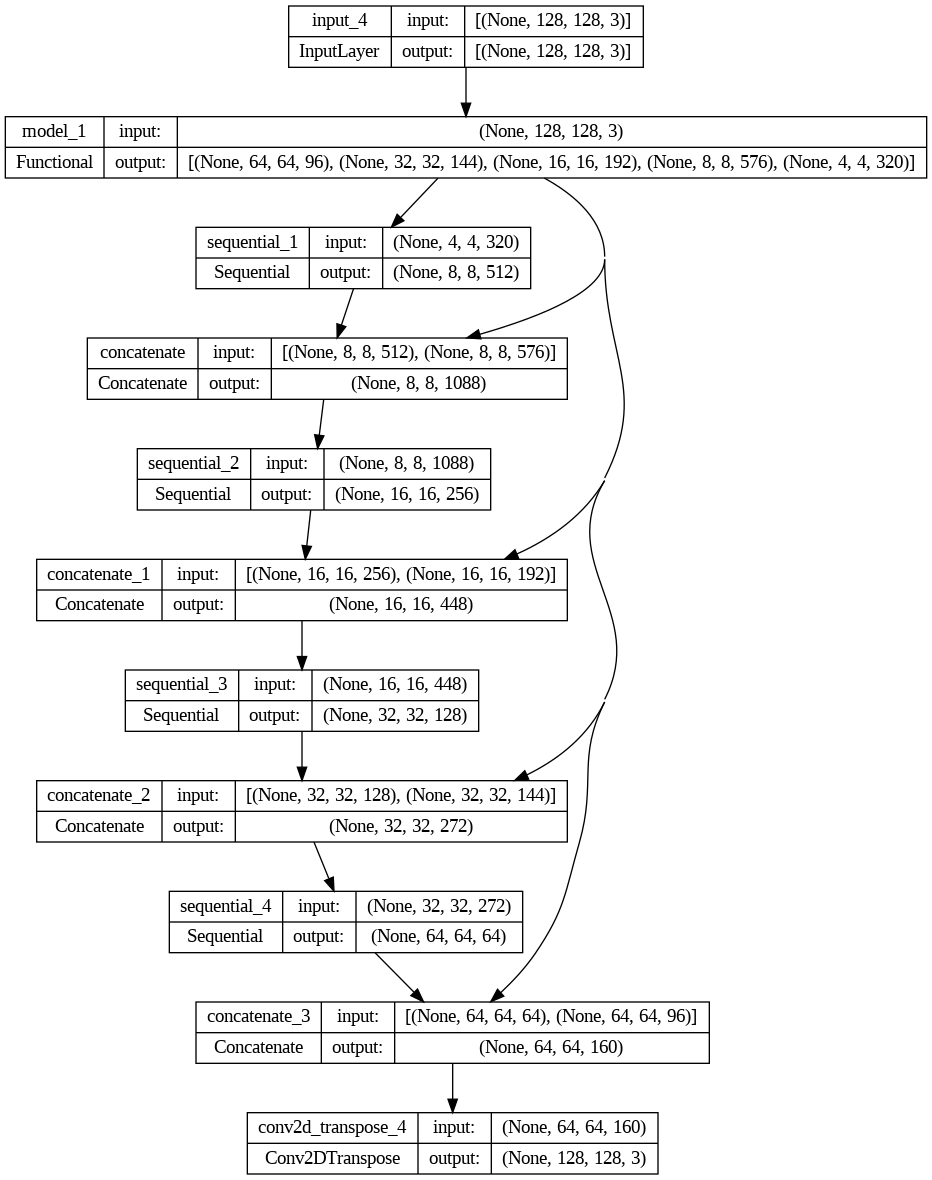

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
29/29 [==============================] - 597s 20s/step - loss: 0.5979 - sparse_categorical_accuracy: 0.7641 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.7805
Epoch 2/10
29/29 [==============================] - 547s 19s/step - loss: 0.3310 - sparse_categorical_accuracy: 0.8798 - val_loss: 0.3397 - val_sparse_categorical_accuracy: 0.8784
Epoch 3/10
29/29 [==============================] - 548s 19s/step - loss: 0.2867 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.3209 - val_sparse_categorical_accuracy: 0.8810
Epoch 4/10
29/29 [==============================] - 551s 19s/step - loss: 0.2673 - sparse_categorical_accuracy: 0.8980 - val_loss: 0.3022 - val_sparse_categorical_accuracy: 0.8875
Epoch 5/10
29/29 [==============================] - 510s 18s/step - loss: 0.2525 - sparse_categorical_accuracy: 0.9024 - val_loss: 0.3034 - val_sparse_categorical_accuracy: 0.8837
Epoch 6/10
29/29 [==============================] - 507s 18s/step - loss: 0.2429 - sparse_categorica

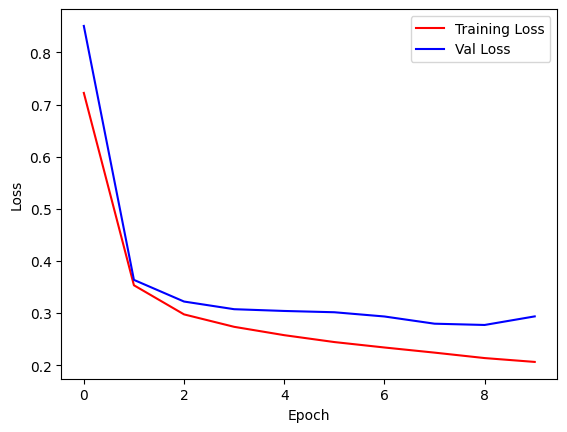

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



#### Evaluation

In [ ]:
print(ds_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


4/4 [==============================] - 5s 32ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 45ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 34ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 31ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)


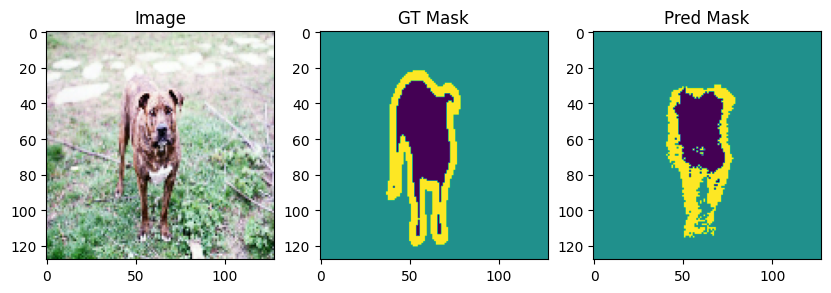

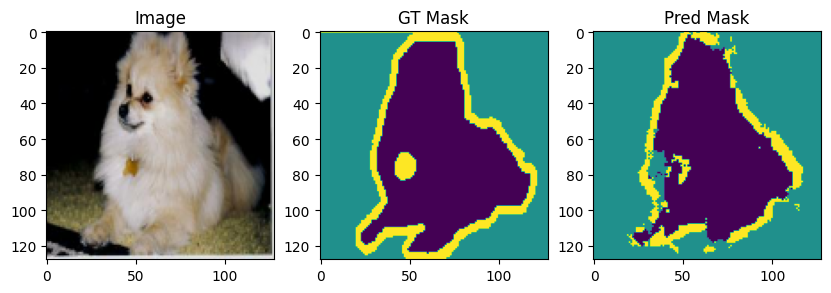

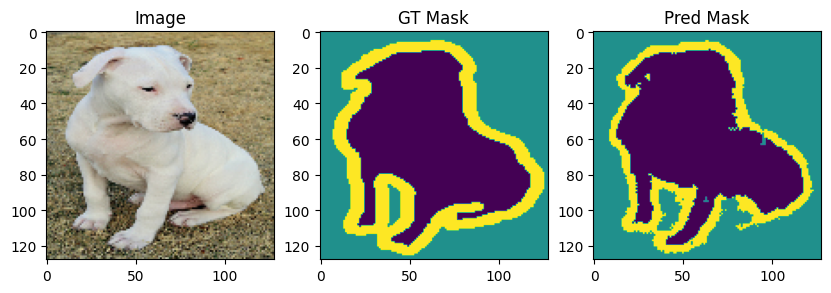

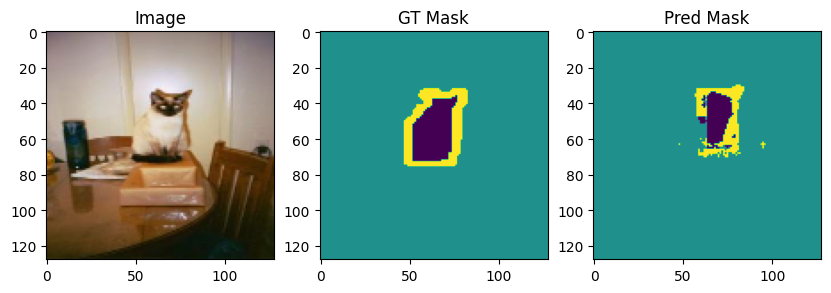

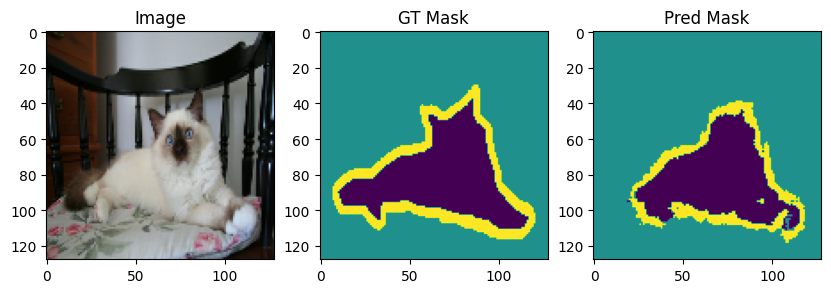

In [ ]:
for (image, mask) in ds_test.take(5):
  pred_mask = model.predict(image)
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  print(image.shape, mask.shape, pred_mask.shape)

  plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.title('Image')
  plt.imshow(image[0])

  plt.subplot(1, 3, 2)
  plt.title('GT Mask')
  plt.imshow(mask[0])

  plt.subplot(1, 3, 3)
  plt.title('Pred Mask')
  plt.imshow(pred_mask[0])

### Breed Classification

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.1 MB/s e

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
from fastai.vision.all import *
import timm
import gradio as gr

In [ ]:
path = untar_data(URLs.PETS)/'images'
 """
Here, we define the path to the dataset. untar_data(URLs.PETS) downloads and extracts
the Pets dataset from the FastAI dataset repository, and /'images' specifies that we are interested
in the image data within the dataset.
"""



In [ ]:
dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=RegexLabeller(pat = r'^([^/]+)_\d+'),
    item_tfms=Resize(224))

'''
This section sets up the data loading pipeline using FastAI's ImageDataLoaders class.

get_image_files(path): This function retrieves the paths to all image files within the specified path (path).
valid_pct=0.2: This parameter sets the percentage of the dataset to be used for validation (20% in this case).
seed=42: This sets the seed for reproducibility during data splitting.

label_func=RegexLabeller(pat = r'^([^/]+)_\d+'): This specifies a regular expression pattern (pat)
 to extract labels from the filenames of the images.
 In this case, it extracts the class labels from the filenames based on the convention <class_name>_<index>.

 item_tfms=Resize(224): This applies image transformations to each item (image) in the dataset.
 In this case, it resizes each image to have a width and height of 224 pixels.
'''

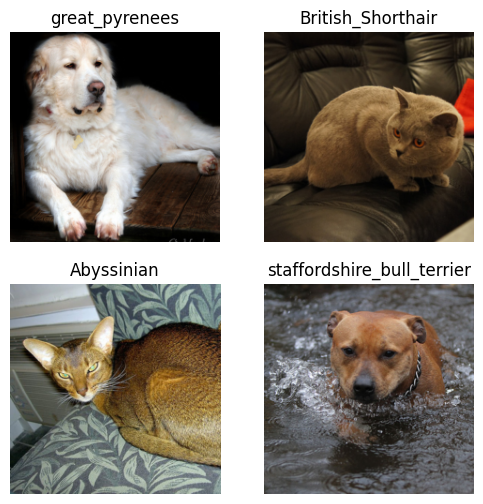

In [ ]:
dls.show_batch(max_n=4)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
'''Here, we're creating a learner object (learn) using the vision_learner function provided by the FastAI library.
 This function is used to instantiate a learner object for training a deep learning model on image data.

 resnet34: This specifies the model architecture to be used for training.
 In this case, we're using the ResNet-34 architecture.
 resnet34 is a function that creates a ResNet-34 model architecture.
 The FastAI library provides various pre-defined model architectures for convenience.


metrics=error_rate: This argument specifies the evaluation metric(s) to be used during training.
In this case, we're using error_rate as the metric,
which calculates the classification error rate (percentage of incorrectly classified examples) on the validation set.



'''
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 40.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.509624,0.336939,0.098782,00:52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.435370,0.348858,0.103518,00:57
1,0.272116,0.256240,0.075101,00:52
2,0.134119,0.244422,0.073072,00:51


*We could try a better model, based on this analysis. The convnext models work great!*

In [ ]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [ ]:
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate).to_fp16()

'''
The .to_fp16() method in FastAI is used to enable mixed-precision training.
Mixed-precision training is a technique that uses 16-bit floating-point numbers (half-precision)
 instead of the standard 32-bit floating-point numbers (single-precision) for model training.


'''
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.130720,0.255913,0.084574,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.290224,0.229604,0.076455,00:52
1,0.201120,0.165044,0.052774,00:53
2,0.128323,0.156815,0.048038,00:51


In [ ]:
learn.export('pet_fastai_model.pkl')

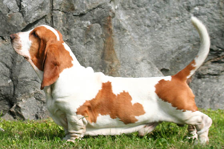

In [ ]:
im = PILImage.create('basset.jpg')
im.thumbnail((224,224))
im

In [ ]:
learn.predict(im)

('basset_hound',
 tensor(14),
 tensor([1.9070e-06, 1.0415e-05, 2.7567e-07, 1.7050e-07, 4.9144e-07, 8.3364e-06,
         1.4339e-06, 6.3225e-07, 4.7725e-07, 1.0965e-07, 1.1086e-06, 5.2193e-06,
         1.9978e-05, 3.4723e-05, 9.9751e-01, 2.1651e-03, 1.2260e-05, 3.3182e-08,
         5.8425e-06, 7.1086e-07, 9.9385e-06, 8.5746e-07, 1.4000e-06, 2.8134e-06,
         8.4677e-06, 3.3513e-07, 3.5259e-07, 1.4339e-06, 2.9321e-06, 1.5398e-06,
         1.9066e-04, 1.6017e-07, 5.8246e-07, 4.6431e-08, 2.4280e-07, 2.6253e-07,
         3.9104e-07]))

In [ ]:
learn = load_learner('pet_fastai_model.pkl')

In [ ]:
#export
categories = learn.dls.vocab

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [ ]:
classify_image(im)

{'Abyssinian': 1.4690498346681125e-06,
 'Bengal': 5.074998261989094e-05,
 'Birman': 8.794747259344149e-07,
 'Bombay': 5.002625584893394e-07,
 'British_Shorthair': 5.129475653120608e-07,
 'Egyptian_Mau': 2.7058553314418532e-05,
 'Maine_Coon': 3.5751403629546985e-05,
 'Persian': 5.602161650131166e-07,
 'Ragdoll': 5.09559276906657e-06,
 'Russian_Blue': 3.336037934786873e-07,
 'Siamese': 7.89317891758401e-06,
 'Sphynx': 8.716421689314302e-06,
 'american_bulldog': 3.22197302011773e-05,
 'american_pit_bull_terrier': 0.0001903441152535379,
 'basset_hound': 0.9959267377853394,
 'beagle': 0.00309629924595356,
 'boxer': 9.00225350051187e-05,
 'chihuahua': 1.1891732043523007e-07,
 'english_cocker_spaniel': 4.19071911892388e-05,
 'english_setter': 5.767793936684029e-06,
 'german_shorthaired': 4.059389084432041e-06,
 'great_pyrenees': 2.489810412953375e-06,
 'havanese': 2.735150474109105e-06,
 'japanese_chin': 3.0346856874530204e-05,
 'keeshond': 3.748698509298265e-05,
 'leonberger': 2.469643277436

### Model Deployment

#### Building a Gradio Application

https://huggingface.co/spaces/Vasanthgx/oxford_pets_breed_classification

In [ ]:
# image = gr.Image()
# label = gr.Label(num_top_classes=5)
# examples = ['cat_russian_blue.jpg','cat_bombay.jpg','cat_abyssinian.jpg','dog_saint_bernard.jpg','dog_shih_tzu.jpg','dog_alabai(central_asian_shepherd_dog).jpg','basset.jpg']

In [ ]:
# intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples,theme='freddyaboulton/dracula_revamped')
# # intf = gr.Interface(fn=classify_image, inputs=image, outputs=label,
# # examples=examples,theme='HaleyCH/HaleyCH_Theme' )
# intf.launch()